# Channel capacity from experimental data.

In [2]:
import pickle
import os
import glob
import re
import datetime
import itertools

# Our numerical workhorses
import numpy as np
from sympy import mpmath
import scipy.optimize
import scipy.special
import scipy.integrate
import pandas as pd

# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import AstroPy for bining histogram data
from astropy.stats import knuth_bin_width

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import evolution_bits_utils as evo_utils

evo_utils.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

figdir = '../../fig/channel_capacity_experiment/'
outputdir = '../../output/channel_capacity_experiment/'
tmpdir = '../../tmp/'
theorydir = '../../output/blahut_algorithm_channel_capacity/'

# Generate a variable with the day that the script is run
today = str(datetime.datetime.today().strftime('%Y%m%d'))

# Extracting the channel capacity from experimental data.

Now that we have the zero parameter-fit theoretical predictions of what the channel capacity should be, let's analyze some experimental data. To get us going in this analysis we will use the data generated for the [`mwc_induction`](https://github.com/RPGroup-PBoC/mwc_inductioN) project.

One interesting aspect to explore with the experimental data is how to bin the outcome properly. Since we don't know the relation between the arbitrary fluorescent measurements from the Flow Cytometer and the number of fluorescent proteins, there is not a clear scheme on how to bin the data. But the channel capacity is always bounded by the maximum entropy of the variables involved, i.e.
\begin{equation}
C = \max_{P(C)}I(C,m) \leq \min \left[ H(C), H(m) \right],
\end{equation}
where $m$ is either protein or mRNA molecules, and $H(X)$ is the shannon entropy of the random variable $X$.

For the 12 experimental concentrations the maximum channel capacity we could aspire would be when all concentrations of IPTG had the same probability given an upper bound of $\log_2(12) \approx 3.58 $ bits. So with such a low upper bound there must be a point in which binning the flow cytometer data more finely won't increase the channel capacity.

To process the data we will use the same scheme as the one used in the `mwc_induction` project fitting a bivariate Gaussian to the front and side scattering as explained [here](https://github.com/RPGroup-PBoC/mwc_induction/blob/master/code/analysis/unsupervised_gating.ipynb).

## Reading and plotting the distributions for one strain.

To begin our exploration of the theoretical data let's use as an example the `O2+11-YFP; RBS1027-lacI` strain. Let's read the data and plot the distributions.

### Flow cytometry data

In [3]:
# Determine patterns to read the data
datadir = \
'/Users/razo/Documents/PhD/RPGroup-PBoC_github/mwc_induction/data/flow/csv/'
date = 20160810
operator = 'O2'
rbs = 'RBS1027'
concentrations = [0, 0.1, 5, 10, 25, 50, 75, 100, 250, 500, 1000, 5000] # uM IPTG

# define the parameter alpha for the automatic gating
alpha = 0.40

# initialize the list to keep the filtered single cell reads.
flow_list = list()
# read the files and perform the bivariate gaussian filter
for i, c in enumerate(concentrations):
    r_file = glob.glob(datadir + str(date) + '*' + operator + '_' + \
            rbs + '_' + str(c) + 'uM' + '*csv')
    print(r_file)
    # read the csv file
    dataframe = pd.read_csv(r_file[0])
    # apply an automatic bivariate gaussian gate to the log front
    # and side scattering
    flow_list.append(evo_utils.auto_gauss_gate(dataframe, alpha, 
                                x_val='FSC-A', y_val='SSC-A',
                                log=True)['FITC-A'])

['/Users/razo/Documents/PhD/RPGroup-PBoC_github/mwc_induction/data/flow/csv/20160810_r2_wt_O2_RBS1027_0uMIPTG.csv']


/Users/razo/Documents/PhD/evolution_bits/src/continuous_game/evolution_bits_utils.py:2211: RuntimeWarning: invalid value encountered in log10
  x = np.log10(df[x_val])
/Users/razo/Documents/PhD/evolution_bits/src/continuous_game/evolution_bits_utils.py:2267: RuntimeWarning: invalid value encountered in log10
  x_vect = np.log10(np.array(df[[x_val, y_val]]))
/Users/razo/Documents/PhD/evolution_bits/src/continuous_game/evolution_bits_utils.py:2316: RuntimeWarning: invalid value encountered in less_equal
  idx = interval_array <= scipy.stats.chi2.ppf(alpha, 2)


['/Users/razo/Documents/PhD/RPGroup-PBoC_github/mwc_induction/data/flow/csv/20160810_r2_wt_O2_RBS1027_0.1uMIPTG.csv']
['/Users/razo/Documents/PhD/RPGroup-PBoC_github/mwc_induction/data/flow/csv/20160810_r2_wt_O2_RBS1027_5uMIPTG.csv']
['/Users/razo/Documents/PhD/RPGroup-PBoC_github/mwc_induction/data/flow/csv/20160810_r2_wt_O2_RBS1027_10uMIPTG.csv']
['/Users/razo/Documents/PhD/RPGroup-PBoC_github/mwc_induction/data/flow/csv/20160810_r2_wt_O2_RBS1027_25uMIPTG.csv']


/Users/razo/Documents/PhD/evolution_bits/src/continuous_game/evolution_bits_utils.py:2212: RuntimeWarning: invalid value encountered in log10
  y = np.log10(df[y_val])


['/Users/razo/Documents/PhD/RPGroup-PBoC_github/mwc_induction/data/flow/csv/20160810_r2_wt_O2_RBS1027_50uMIPTG.csv']
['/Users/razo/Documents/PhD/RPGroup-PBoC_github/mwc_induction/data/flow/csv/20160810_r2_wt_O2_RBS1027_75uMIPTG.csv']
['/Users/razo/Documents/PhD/RPGroup-PBoC_github/mwc_induction/data/flow/csv/20160810_r2_wt_O2_RBS1027_100uMIPTG.csv']
['/Users/razo/Documents/PhD/RPGroup-PBoC_github/mwc_induction/data/flow/csv/20160810_r2_wt_O2_RBS1027_250uMIPTG.csv']
['/Users/razo/Documents/PhD/RPGroup-PBoC_github/mwc_induction/data/flow/csv/20160810_r2_wt_O2_RBS1027_500uMIPTG.csv']
['/Users/razo/Documents/PhD/RPGroup-PBoC_github/mwc_induction/data/flow/csv/20160810_r2_wt_O2_RBS1027_1000uMIPTG.csv']
['/Users/razo/Documents/PhD/RPGroup-PBoC_github/mwc_induction/data/flow/csv/20160810_r2_wt_O2_RBS1027_5000uMIPTG.csv']


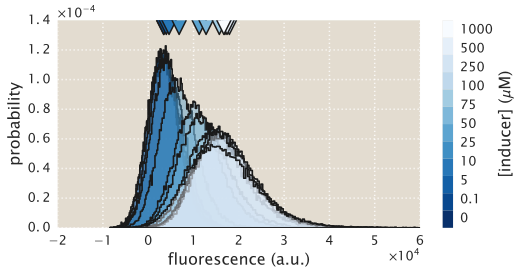

In [4]:
colors = sns.color_palette("Blues_r", len(concentrations))
fig = plt.figure(figsize=(7.5, 4))
ax = plt.subplot(111)
# Set the nice scientific notation for the y axis of the histograms
ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(\
                             useMathText=True, 
                             useOffset=False))
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter(\
                             useMathText=True, 
                             useOffset=False))
for i, c in enumerate(concentrations):
    n, bins, patches = plt.hist(flow_list[i], 200,
                                normed=1, histtype='stepfilled', alpha=0.4,
                                label=str(c)+ r' $\mu$M', facecolor=colors[i],
                               linewidth=1.5)
    n, bins, patches = plt.hist(flow_list[i], 200,
                                normed=1, histtype='stepfilled', 
                                label='', edgecolor='k',
                               linewidth=1.5, facecolor='none')

# Declare color map for legend
cmap = plt.cm.get_cmap('Blues_r', len(concentrations))
bounds = np.linspace(0, len(concentrations), len(concentrations) + 1)

# Plot a little triangle indicating the mean of each distribution
mean_fl = [np.mean(f) for f in flow_list]
mean_plot = ax.scatter(mean_fl, [1.4E-4] * len(mean_fl), marker='v', s=800,
            c=np.arange(len(mean_fl)), cmap=cmap,
            edgecolor='k',
            linewidth=1.5)
# Generate a colorbar with the concentrations
cbar = fig.colorbar(mean_plot)
cbar.set_ticks(bounds[:-1] + 0.5)
cbar.set_ticklabels(concentrations)
cbar.set_label(r'[inducer] ($\mu$M)')

# Format the plot
ax.set_ylim([0, 0.00014])
ax.set_xlim([-20000, 60000])
ax.set_xlabel('fluorescence (a.u.)')
ax.set_ylabel('probability')
ax.ticklabel_format(style='sci', scilimits=(0,0))

plt.tight_layout()
plt.savefig(figdir + 'RBS1027_histograms.pdf')

Now we define a function to compute the ECDF

In [5]:
def ecdf(data):
    return np.sort(data), np.arange(1, len(data)+1) / len(data)

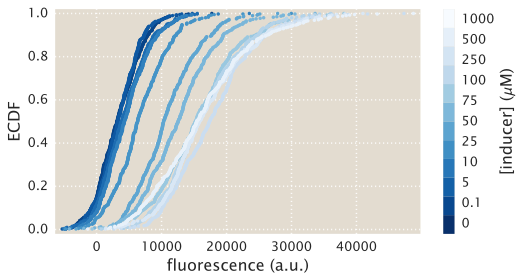

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 4))
for i, c in enumerate(concentrations):
    x, y = ecdf(flow_list[i][::100])
    ax.plot(x, y, '.', label=str(c)+ r' $\mu$M', color=colors[i])

# Declare color map for legend
cmap = plt.cm.get_cmap('Blues_r', len(concentrations))
bounds = np.linspace(0, len(concentrations), len(concentrations) + 1)

# Plot a little triangle indicating the mean of each distribution
mean_fl = [np.mean(f) for f in flow_list]
mean_plot = ax.scatter(mean_fl, [0] * len(mean_fl), marker='^', s=0,
            c=np.arange(len(mean_fl)), cmap=cmap,
            edgecolor='k',
            linewidth=1.5)

# Generate a colorbar with the concentrations
cbar = fig.colorbar(mean_plot)
cbar.set_ticks(bounds[:-1] + 0.5)
cbar.set_ticklabels(concentrations)
cbar.set_label('[inducer] ($\mu$M)')
    
# Format axis
ax.margins(0.02)
ax.set_xlabel('fluorescence (a.u.)')
ax.set_ylabel('ECDF')

plt.tight_layout()
plt.savefig(figdir + 'RBS1027_ecdf.pdf')

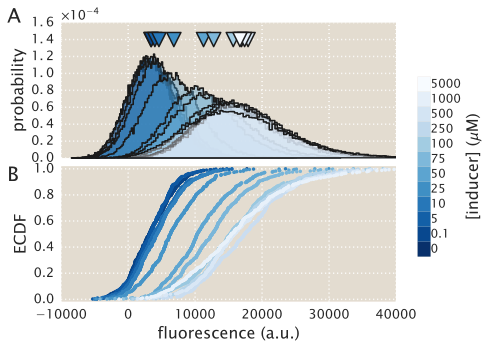

In [45]:
colors = sns.color_palette("Blues_r", len(concentrations))

fig, ax = plt.subplots(2, 1, figsize=(6,5), sharex=True)

# Set the nice scientific notation for the y axis of the histograms
ax[0].yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(\
                             useMathText=True, 
                             useOffset=False))
ax[0].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter(\
                             useMathText=True, 
                             useOffset=False))

for i, c in enumerate(concentrations):
    # Histogram plot
    n, bins, patches = ax[0].hist(flow_list[i], 200,
                                normed=1, histtype='stepfilled', alpha=0.4,
                                label=str(c)+ r' $\mu$M', facecolor=colors[i],
                               linewidth=1)
    n, bins, patches = ax[0].hist(flow_list[i], 200,
                                normed=1, histtype='stepfilled', 
                                label='', edgecolor='k',
                               linewidth=1.5, facecolor='none')
    # ECDF Plot
    x, y = ecdf(flow_list[i][::100])
    ax[1].plot(x, y, '.', label=str(c)+ r' $\mu$M', color=colors[i])

# Declare color map for legend
cmap = plt.cm.get_cmap('Blues_r', len(concentrations))
bounds = np.linspace(0, len(concentrations), len(concentrations) + 1)

# Plot a little triangle indicating the mean of each distribution
mean_fl = [np.mean(f) for f in flow_list]
mean_plot = ax[0].scatter(mean_fl, [1.4E-4] * len(mean_fl), marker='v', s=200,
            c=np.arange(len(mean_fl)), cmap=cmap,
            edgecolor='k',
            linewidth=1.5)
# Generate a colorbar with the concentrations
cbar_ax = fig.add_axes([0.95, 0.25, 0.03, 0.5])
cbar = fig.colorbar(mean_plot, cax=cbar_ax)
cbar.ax.get_yaxis().set_ticks([])
for j, c in enumerate(concentrations):
    if c == 0.1:
        c = str(c)
    else:
        c = str(int(c))
    cbar.ax.text(1, j / len(concentrations) + 1 / (2 * len(concentrations)),
                 c, ha='left', va='center',
                 transform = cbar_ax.transAxes, fontsize=12)
cbar.ax.get_yaxis().labelpad = 35
cbar.set_label(r'[inducer] ($\mu$M)')

ax[0].set_ylim([0, 0.00016])
ax[0].set_xlim([-10000, 40000])
ax[0].set_ylabel('probability')
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
 
ax[1].margins(0.02)
ax[1].set_xlim([-10000, 40000])
ax[1].set_xlabel('fluorescence (a.u.)')
ax[1].set_ylabel('ECDF')

plt.figtext(0.0, .9, 'A', fontsize=20)
plt.figtext(0.0, .46, 'B', fontsize=20)

plt.subplots_adjust(hspace=0.06)
plt.savefig(figdir + 'RBS1027_distribution.pdf', bbox_inches='tight')

### Microscopy data

In [10]:
datadir = '/Users/razo/Documents/PhD/RPGroup-PBoC_github/mwc_induction/data/'

df_micro = pd.read_csv(datadir + \
                       'RBS1027_O2_microscopy_cell_intensities.csv')
df_micro.head()

Unnamed: 0      date username operator  binding_energy   rbs  repressors  \
0           0  20161018   gchure       O2           -13.9  auto           0   
1           0  20161018   gchure       O2           -13.9  auto           0   
2           0  20161018   gchure       O2           -13.9  auto           0   
3           0  20161018   gchure       O2           -13.9  auto           0   
4           0  20161018   gchure       O2           -13.9  auto           0   

   IPTG_uM    area  eccentricity  solidity  mean_intensity  
0      0.0  2.5344      0.836521  0.942857      134.154620  
1      0.0  2.7136      0.882338  0.921739      118.181348  
2      0.0  4.3776      0.946937  0.872449      120.647971  
3      0.0  5.6320      0.831335  0.956522      122.134728  
4      0.0  2.8416      0.878814  0.948718      113.355678

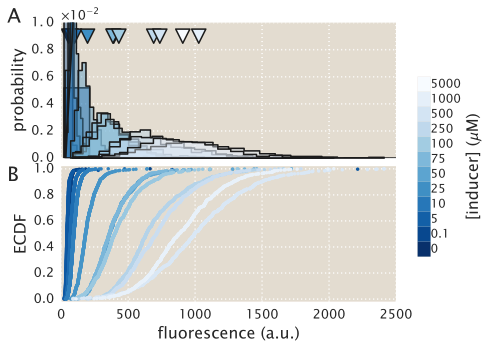

In [43]:
# Select RBS1027 day 1 to start the data exploration
df_1027_d1 = df_micro.groupby(['date', 'rbs']).get_group(\
                                          (df_micro.date.unique()[0], 'RBS1027'))
df_group = df_1027_d1.groupby('IPTG_uM')

concentrations = df_1027_d1.IPTG_uM.unique()
# Plot distributions coming from microscopy
# Decide color
colors = sns.color_palette("Blues_r", len(concentrations))

fig, ax = plt.subplots(2, 1, figsize=(6,5), sharex=True)

# Set the nice scientific notation for the y axis of the histograms
ax[0].yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(\
                             useMathText=True, 
                             useOffset=False))
ax[0].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter(\
                             useMathText=True, 
                             useOffset=False))
i = 0
nbins = 20 
mean_fl = []
for g, data in df_group:
    # Histogram plot
    n, bins, patches = ax[0].hist(data.mean_intensity, nbins,
                                normed=1, histtype='stepfilled', alpha=0.4,
                                label=str(c)+ r' $\mu$M', facecolor=colors[i],
                               linewidth=1)
    n, bins, patches = ax[0].hist(data.mean_intensity, nbins,
                                normed=1, histtype='stepfilled', 
                                label='', edgecolor='k',
                               linewidth=1.5, facecolor='none')
    mean_fl.append(data.mean_intensity.mean())
    # ECDF Plot
    x, y = ecdf(data.mean_intensity)
    ax[1].plot(x, y, '.', label=str(c)+ r' $\mu$M', color=colors[i])
    i += 1

# Declare color map for legend
cmap = plt.cm.get_cmap('Blues_r', len(concentrations))
bounds = np.linspace(0, len(concentrations), len(concentrations) + 1)

# Plot a little triangle indicating the mean of each distribution
mean_plot = ax[0].scatter(mean_fl, [9E-3] * len(mean_fl), marker='v', s=200,
            c=np.arange(len(mean_fl)), cmap=cmap,
            edgecolor='k',
            linewidth=1.5)
# Generate a colorbar with the concentrations
cbar_ax = fig.add_axes([0.95, 0.25, 0.03, 0.5])
cbar = fig.colorbar(mean_plot, cax=cbar_ax)
cbar.ax.get_yaxis().set_ticks([])
for j, r in enumerate(concentrations):
    if r == 0.1:
        r = str(r)
    else:
        r = str(int(r))
    cbar.ax.text(1, j / len(concentrations) + 1 / (2 * len(concentrations)),
                 r, ha='left', va='center',
                 transform = cbar_ax.transAxes, fontsize=12)
cbar.ax.get_yaxis().labelpad = 35
cbar.set_label(r'[inducer] ($\mu$M)')

    
ax[0].set_ylim([0, 1E-2])
ax[0].set_ylabel('probability')
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
 
ax[1].margins(0.02)
ax[1].set_xlim([0, 2500])
ax[1].set_xlabel('fluorescence (a.u.)')
ax[1].set_ylabel('ECDF')

plt.figtext(0.0, .9, 'A', fontsize=20)
plt.figtext(0.0, .46, 'B', fontsize=20)

plt.subplots_adjust(hspace=0.06)
plt.savefig(figdir + 'RBS1027_distribution_microscopy.pdf', bbox_inches='tight')

We can see from these plots that even after the filtering with the bivatiate Gaussian there is a very long tail (seen by the  range of the plotting). But we don't really have to filter them at this point, when building the transition matrix `QmC` we can always ignore bins that have a very low probability for all concentrations of IPTG.

Let's be systematic about the effect of the number of bins, and the effect of the parameter $\alpha$ (i.e. % of data kept after gating). We will save the transition matrices `QmC` with the following format:

`QmC_date_operator_rbs_alpha_nbins.csv`,

where `alpha` is the parameter used in the bivariate Gaussian gating and `nbins` is the number of bins set.

Let's define a function that returns the experimentally determined `QmC`.

In [6]:
def trans_matrix_exp(flow_list, bins, tol=1E-8):
    '''
    Builds the transition matrix P(m|C) from experimental data contained in a
    list flow_list, where each element of the list is the output readings from
    individual cells at a specific concentration.
    Parameters
    ----------
    flow_list : list.
        Single cell output reads (from flow cytometry or microscopy) measured at
        different inducer concentrations. The length of the list is assumed to
        be the number of concentrations in the data set.
    bins : int.
        Number of bins to use when building the empirical PMF of the data set.
        If `bins` is a string from the list below, `histogram` will use
        the method chosen to calculate the optimal bin width and
        consequently the number of bins from the data that falls within 
        the requested range.
    tol : float.
        Threshold value for which if a bin has a probability less than this
        in all concentrations it is dropped out of the matrix. This avoids
        numerical errors when working with bins that have very small
        probabilities.
        
    Returns
    -------
    QmC : array-like.
        Experimentally determined input-output function.
    '''
    # indicate the range in which bin the data
    bin_range = [np.min([np.min(x) for x in flow_list]),
                 np.max([np.max(x) for x in flow_list])]
    
    if isinstance(bins, str):
        # Joining the data into a single array
        flow_data = np.array([])
        for f in flow_list:
            flow_data = np.append(flow_data, f)
        # Determine the number of bins by counting the edges when
        # binning the data. NOTE: There is definitely more efficient ways
        # to do this, but this step is so fast that we can ignore my non-
        # efficient algorithm.
        hist, edges = np.histogram(flow_data, bins)
        nbins = len(edges) 
    else:
        nbins = bins
    # Initialize transition matrix
    QmC = np.zeros([nbins, len(flow_list)])
    for k, f in enumerate(flow_list):
        # Obtain the empirical PMF from the experimental data
        p, bin_edges = np.histogram(f, bins=int(nbins), range=bin_range)
        # Normalized the empirical PMF. We don't use the option from numpy
        # because it DOES NOT build a PMF but assumes a PDF.
        p = p / np.sum(p)
        QmC[:, k] = p
        
    # Eliminate the fluorescent counts on which for all concentrations 
    # the probability is always zero or very close to it
    QmC = QmC[np.sum(QmC, axis=1) >= tol, :]
    
    return QmC

## Testing the effect of the number of bins on the channel capacity.

Let's compute the channel capacity for different number of bins and plot the channel capacity as a function of the number of bins.

In [38]:
nbins = np.floor(np.logspace(2, 5, 20))

def chan_cap_parallel(n):
    QmC = trans_matrix_exp(flow_list, n, 1E-10)
    # Compute the channel capacity for the transition matrix QmC
    Il, pC, loop_count = evo_utils.channel_capacity(QmC.T, 1E-6)
    return Il
chan_cap = Parallel(n_jobs=7)(delayed(chan_cap_parallel)(n) \
                                   for n in nbins)

/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/razo/anaconda/lib/python3.5/site-packages/ipyker

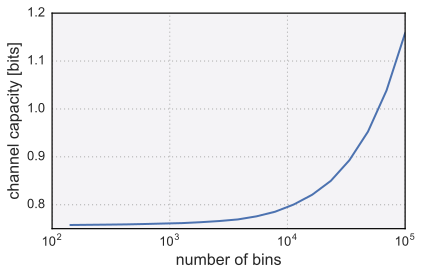

In [39]:
plt.plot(nbins, chan_cap)
plt.xlabel('number of bins')
plt.ylabel('channel capacity [bits]')
plt.xscale('log')
plt.tight_layout()
plt.savefig(figdir + 'binning_bias_problem.pdf')

There is definitely a very significant effect on the channel capacity depending on the number of bins.

# Automatic selection of number of bins.

Let's try using the [Freedman-Diaconis](https://en.wikipedia.org/wiki/Freedman–Diaconis_rule) rule to automatically set the number of bins for the data set.

In [63]:
QmC = trans_matrix_exp(flow_list, 'fd', 1E-10)
# Compute the channel capacity for the transition matrix QmC
Il, pC, loop_count = evo_utils.channel_capacity(QmC.T, 1E-6)
print('channel capacity: {:0.2f} bits'.format(Il))

channel capacity: 0.76 bits


# Computing the channel capacity for the rest of the data-sets

Let's for now use this Freedman-Diaconis rule for bining the data an let's compute the channel capacity for all of the available data sets.

First let's define a function that finds all the features in a file name, i.e. date, run (if listed), strain, operator and IPTG concentration.

In [7]:
def parse_filename(filename):
    '''
    Parses the information contained in a filename extracting the following
    features:
    date, run, operator, strain and IPTG concentration.
    Parameters
    ----------
    filename : string
        path to the raw file
    returns
    -------
    Pandas series listing all the features from this filename name
    '''
    rbs = ['auto', 'delta', 'RBS1L', 'RBS1', 'RBS1027', 'RBS446', 
           'RBS1147', 'HG104']
    operator = ['O1', 'O2', 'O3', 'Oid']
    # Extract the date
    day = re.findall('201.....', filename)[0]
    # Split the filename by the underscore character
    split = re.split('_', filename)
    # extract the IPTG concentration
    iptg = re.sub('.csv', '', [c for c in split if 'IPTG' in c][0])
    # extract the strain
    strain = [r for r in split for R in rbs if r in R][0]
    # Extract the operator
    op = [o for o in split for O in operator if o in O][0]
    # Extract the run, if there is no run listed it gives 'none'
    run = re.findall('r._', filename)
    if len(run)==0: run = 'none'
    else: run = re.sub('_', '', run[0])
    return pd.Series([day, run, op, iptg, strain, filename], 
                     index=['date', 'run', 'operator', 'IPTG', 'rbs', 'file'])

To obtain automatically some of the necessary parameters such as the set of mutants, their mean repressor copy number and so on we will first read the all the processed data from the mwc_induction project.

In [8]:
datadir = \
'/Users/razo/Documents/PhD/RPGroup-PBoC_github/mwc_induction/data/'
# read the list of data-sets to ignore
data_ignore = pd.read_csv(datadir + 'datasets_ignore.csv', header=None).values
# read the all data sets except for the ones in the ignore list
all_files = glob.glob(datadir + '*' + '_IPTG_titration' + '*csv')
ignore_files = [f for f in all_files for i in data_ignore if i[0] in f]
read_files = [f for f in all_files if f not in ignore_files]
print('Number of independent data-sets: {:d}'.format(len(read_files)))
df = pd.concat(pd.read_csv(f, comment='#') for f in read_files)

# Now we remove the autofluorescence and delta values
# df = df[(df.rbs != 'auto') & (df.rbs != 'delta')]

df[['date', 'operator', 'rbs', 'IPTG_uM']].head()

Number of independent data-sets: 32


date operator      rbs  IPTG_uM
0  20160804       O2     auto      0.0
1  20160804       O2    delta      0.0
2  20160804       O2    RBS1L      0.0
3  20160804       O2     RBS1      0.0
4  20160804       O2  RBS1027      0.0

Let's now extract the relevant information from this data frame.

In [66]:
# unique set of RBS mutants
rbs = df.rbs.unique()
# unique set of operators
operator = df.operator.unique()
# unique set of dates
dates = df.date.unique()
# unique set of concentrations
concentrations = np.sort(df.IPTG_uM.unique())

# Build the pattern that the files that will be ignored must have.
ignore_pattern = [re.sub('_IPTG_titration_MACSQuant.csv', '', f[0]) \
                  for f in data_ignore]
ignore_pattern = [re.sub('_O', '_wt_O', f) for f in ignore_pattern]

In [88]:
# List the directory with all of the data
flowdir =\
'/Volumes/razo_data/mwc_induction/csv/'

# List IPTG titration files
# All the files in data
all_files = glob.glob(flowdir + '*') 
# Files that actually contain IPTG titration data
titration_files = [f for f in all_files for i in dates if str(i) in f]
# Files that are not listed in the data_ignore.csv list
read_files = [f for f in titration_files for i in ignore_pattern \
                   if i not in f]
read_files = np.unique(read_files)
print('Number of raw files to process: {:d}'.format(len(read_files)))

Number of raw files to process: 2770


In [91]:
df_files = pd.DataFrame()
df_files = df_files.append([parse_filename(f) for f in read_files])
# df_files = df_files[(df_files.rbs!='auto') & (df_files.rbs!='delta')]
df_files.head()

date   run operator        IPTG    rbs  \
0  20160804  none       O2   0.1uMIPTG  HG104   
1  20160804  none       O2     0uMIPTG  HG104   
2  20160804  none       O2  1000uMIPTG  HG104   
3  20160804  none       O2   100uMIPTG  HG104   
4  20160804  none       O2    10uMIPTG  HG104   

                                                file  
0  /Volumes/razo_data/mwc_induction/csv/20160804_...  
1  /Volumes/razo_data/mwc_induction/csv/20160804_...  
2  /Volumes/razo_data/mwc_induction/csv/20160804_...  
3  /Volumes/razo_data/mwc_induction/csv/20160804_...  
4  /Volumes/razo_data/mwc_induction/csv/20160804_...

Now that we have the list of the files to process we can define a function that takes a subset of this data-frame containing single strain data-set and computes the channel capacity for that set.

In [9]:
def channel_cap_set(df_files, bins='fd', alpha=0.4, tol=1E-10, verbose=True):
    '''
    Performs the necessary operations to compute the channel capacity
    given a list of files from a single strain with multiple IPTG concentrations
    Parameters
    ----------
    df_files : pandas DataFrame.
        DataFrame containing the meta data of a single data set. A single
        data set is defined as a signle run for a single strain, for example,
        all the 20160818 files for the RBS1027 mutant.
    alpha : float [0, 1]
        Fraction of the data that should be kept after performing the automatic
        bivariate gating of the flow cytometry data. 
    Returns
    -------
    The channel capacity for that data set.
    '''
    # initialize the list to keep the filetered single cell reads
    flow_list = list()
    IPTG = np.sort(df_files.IPTG)
    # read the files and perform the bivariate gaussian filter
    if verbose:
        print('Processing raw files:')
    for i, c in enumerate(IPTG):
        if verbose:
            print(c)
        # read the csv file
        data = pd.read_csv(df_files[df_files.IPTG == c].iloc[0].file)
        # apply an automatic bivariate gaussian gate to the log front
        # and side scattering
        flow_list.append(evo_utils.auto_gauss_gate(data, alpha, 
                                    x_val='FSC-A', y_val='SSC-A',
                                    log=True)['FITC-A'])
    if verbose:
        print('Computing channel capacity:')
    # Compute the transition matrix.
    QmC = trans_matrix_exp(flow_list, bins, tol)
    # Compute the channel capacity for the transition matrix QmC
    Il, pC, loop_count = evo_utils.channel_capacity(QmC.T, 1E-6)
    if verbose:
        print('Channel capacity = {:0.2f} bits'.format(Il))
    return Il

Now everything is ready to compute the channel capacity for all of the available data sets!

Let's run the beast in parallel to speed up the computation.

In [52]:
grouping = ['date', 'run', 'rbs', 'operator']
# Define the Pandas groupby object grouping by date, run and rbs mutant
groups = df_files.groupby(grouping)

compute_cap = True
if compute_cap:
    # Define the function to run the calculation in parallel
    def capacity_parallel(g, group):
        return channel_cap_set(group, bins='fd', verbose=False)
    chan_cap = Parallel(n_jobs=6)(delayed(capacity_parallel)(g, data) \
                                            for g, data in groups)

    # As always is useful to save the results in a tidy `DataFrame`.
    df_chan_cap = pd.DataFrame(columns=grouping)
    groups = df_files.groupby(grouping)
    for g, data in groups:
        df_chan_cap = df_chan_cap.append(pd.Series(g, index=grouping),
                                         ignore_index=True)
    df_chan_cap['repressors'] = df.groupby('rbs').repressors.unique()\
                                [df_chan_cap.rbs].values.astype(int)
    df_chan_cap['chan_cap'] = chan_cap
    df_chan_cap.to_csv(outputdir + today + '_channel_capacity_fdbins.csv')

loop : 10000, Iu - Il : 0.000004
loop : 20000, Iu - Il : 0.000106
loop : 30000, Iu - Il : 0.000036
loop : 40000, Iu - Il : 0.000009
loop : 50000, Iu - Il : 0.000002
loop : 10000, Iu - Il : 0.000002
loop : 10000, Iu - Il : 0.000002
loop : 10000, Iu - Il : 0.000002
loop : 10000, Iu - Il : 0.000001
loop : 10000, Iu - Il : 0.000003
loop : 10000, Iu - Il : 0.000001
loop : 10000, Iu - Il : 0.000026
loop : 10000, Iu - Il : 0.000002
loop : 10000, Iu - Il : 0.000001


In [10]:
df_chan_cap = pd.read_csv(outputdir + '20160906_channel_capacity_fdbins.csv',
                         index_col=0)

# Drop the channel capacities that came as infty
df_chan_cap = df_chan_cap[df_chan_cap.chan_cap!=np.inf]
df_chan_cap.head()

date   run      rbs operator  repressors  chan_cap
0  20160804  none    HG104       O2          11  0.663166
1  20160804  none     RBS1       O2         610  0.551492
2  20160804  none  RBS1027       O2         130  0.748831
3  20160804  none  RBS1147       O2          30  0.740433
4  20160804  none    RBS1L       O2         870  0.582959

# Plotting the experimental results vs the theory

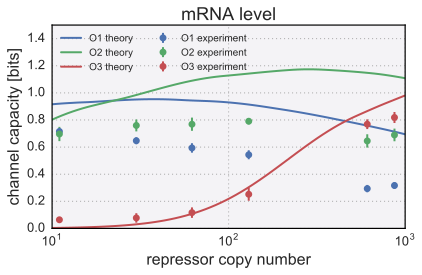

In [55]:
kon_operators = ['O1', 'O2', 'O3']
colors = sns.color_palette(n_colors=len(kon_operators))

fig = plt.figure()
# Load the pickled theoretical predictions
for i, kon in enumerate(kon_operators):
    df_theory = pd.read_csv(theorydir + 'capacity_mRNA_expIPTG_' + kon + '.csv')
    # plot theoretical the channel capacity
    plt.plot(df_theory.repressors, df_theory.channel_capacity, 
             label=kon + ' theory', color=colors[i])
    # compute the mean value for each concentration
    cc_mean = df_chan_cap[df_chan_cap.operator==kon].\
              groupby('rbs').chan_cap.mean()
    # compute the standard error of the mean
    cc_err = df_chan_cap[df_chan_cap.operator==kon].\
              groupby('rbs').chan_cap.std() /\
    np.sqrt(df_chan_cap[df_chan_cap.operator==kon].groupby('rbs').size())
        
        # plot the experimental df_chan_cap
    plt.errorbar(df_chan_cap[df_chan_cap.operator==kon].groupby('rbs').\
                 repressors.unique(), cc_mean,
            yerr=cc_err, fmt='o', label=kon + ' experiment',
            color=colors[i])

# format the plot
plt.xlabel('repressor copy number')
plt.ylabel('channel capacity [bits]')
plt.xscale('log')
plt.xlim([1E1, 1E3])
plt.ylim(bottom=0, top=1.5)
plt.legend(loc=0, ncol=2)
plt.title('mRNA level')
plt.tight_layout()
plt.savefig(figdir + 'chancap_mRNA_thry_exp_literature_param.pdf')

### Plotting the theoretical curves where $k_0$ was fit to the `O2 RBS1027` uninduced data

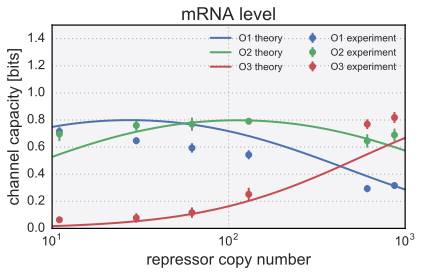

In [140]:
kon_operators = ['O1', 'O2', 'O3']
colors = sns.color_palette(n_colors=len(kon_operators))

fig = plt.figure()
# Load the pickled theoretical predictions
for i, kon in enumerate(kon_operators):
    df_theory = pd.read_csv(theorydir + 'new_capacity_mRNA_expIPTG_' + \
                            kon + '.csv')
    # plot theoretical the channel capacity
    plt.plot(df_theory.repressors, df_theory.channel_capacity, 
             label=kon + ' theory', color=colors[i])
    # compute the mean value for each concentration
    cc_mean = df_chan_cap[df_chan_cap.operator==kon].\
              groupby('rbs').chan_cap.mean()
    # compute the standard error of the mean
    cc_err = df_chan_cap[df_chan_cap.operator==kon].\
              groupby('rbs').chan_cap.std() /\
    np.sqrt(df_chan_cap[df_chan_cap.operator==kon].groupby('rbs').size())
        
        # plot the experimental df_chan_cap
    plt.errorbar(df_chan_cap[df_chan_cap.operator==kon].groupby('rbs').\
                 repressors.unique(), cc_mean,
            yerr=cc_err, fmt='o', label=kon + ' experiment',
            color=colors[i])

# format the plot
plt.xlabel('repressor copy number')
plt.ylabel('channel capacity [bits]')
plt.xscale('log')
plt.xlim([1E1, 1E3])
plt.ylim(bottom=0, top=1.5)
plt.legend(loc=0, ncol=2)
plt.title('mRNA level')
plt.tight_layout()
plt.savefig(figdir + 'chancap_mRNA_thry_exp_noise_fit.pdf')

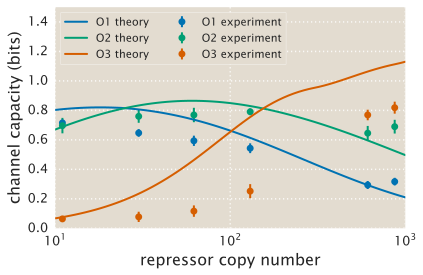

In [14]:
kon_operators = ['O1', 'O2', 'O3']
colors = sns.color_palette(n_colors=len(kon_operators))

fig = plt.figure()
# Load the pickled theoretical predictions
for i, kon in enumerate(kon_operators):
    df_theory = pd.read_csv(theorydir + 'capacity_protein_expIPTG_' + \
                            kon + '_noise_fit.csv')
    # plot theoretical the channel capacity
    plt.plot(df_theory.repressors, df_theory.channel_capacity, 
             label=kon + ' theory', color=colors[i])
    # compute the mean value for each concentration
    cc_mean = df_chan_cap[df_chan_cap.operator==kon].\
              groupby('rbs').chan_cap.mean()
    # compute the standard error of the mean
    cc_err = df_chan_cap[df_chan_cap.operator==kon].\
              groupby('rbs').chan_cap.std() /\
    np.sqrt(df_chan_cap[df_chan_cap.operator==kon].groupby('rbs').size())
        
        # plot the experimental df_chan_cap
    plt.errorbar(df_chan_cap[df_chan_cap.operator==kon].groupby('rbs').\
                 repressors.unique(), cc_mean,
            yerr=cc_err, fmt='o', label=kon + ' experiment',
            color=colors[i])

# format the plot
plt.xlabel('repressor copy number')
plt.ylabel('channel capacity (bits)')
plt.xscale('log')
plt.xlim([1E1, 1E3])
plt.ylim(bottom=0, top=1.5)
plt.legend(loc=0, ncol=2)
# plt.title('protein level')
plt.tight_layout()
plt.savefig(figdir + 'chancap_protein_thry_exp_noise_fit.pdf')

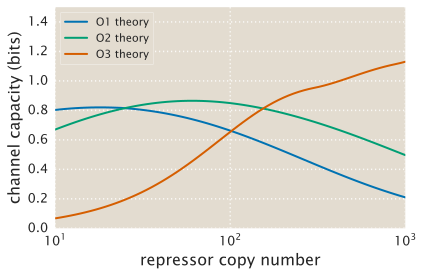

In [47]:
kon_operators = ['O1', 'O2', 'O3']
colors = sns.color_palette(n_colors=len(kon_operators))

fig = plt.figure()
# Load the pickled theoretical predictions
for i, kon in enumerate(kon_operators):
    df_theory = pd.read_csv(theorydir + 'capacity_protein_expIPTG_' + \
                            kon + '_noise_fit.csv')
    # plot theoretical the channel capacity
    plt.plot(df_theory.repressors, df_theory.channel_capacity, 
             label=kon + ' theory', color=colors[i])
        
# format the plot
plt.xlabel('repressor copy number')
plt.ylabel('channel capacity (bits)')
plt.xscale('log')
plt.xlim([1E1, 1E3])
plt.ylim(bottom=0, top=1.5)
plt.legend(loc='upper left', ncol=1)
# plt.title('protein level')
plt.tight_layout()
plt.savefig(figdir + 'chancap_protein_thry_noise_fit.pdf')

# Small noise approximation

Tkacik, Callan and Bialek derived the so-called small noise approximation in which the channel capacity can be computed as

\begin{equation}
C \approx \log_2\left( \frac{Z}{\sqrt{2 \pi e}} \right),
\end{equation}

where

\begin{equation}
Z \equiv \int^{\langle g \rangle_\max}_{\langle g \rangle_\min} \frac{d \langle g \rangle}{\sigma_g (\langle g \rangle)}.
\end{equation}

Here $\langle g \rangle$ is the mean level (of either protein or mRNA) and $\sigma_g$ is the standard deviation of the expression level.

In principle we could try to use this approximation to compute the channel capacity of the experimental measurements. First what we need to do is to obtain the mean fluorescence and the standard deviation for each of the data sets.

In [128]:
alpha = 0.1

# initialize data frame to save the mean and variance
df_noise = pd.DataFrame(columns=['date', 'run', 'operator', 'IPTG',\
                                     'rbs', 'mean_fluor', 'std_fluor'])

# loop through every file and compute the mean and variance
for idx, series in df_files.iterrows():
    if idx%250==0:
        print(idx)
    # Read the csv file
    data = pd.read_csv(series.file)
    # apply an automatic bivariate gaussian gate to the log front
    # and side scattering
    fluor = evo_utils.auto_gauss_gate(data, alpha, 
                                x_val='FSC-A', y_val='SSC-A',
                                log=True)['FITC-A']
    series['mean_fluor'] = fluor.mean()
    series['std_fluor'] = fluor.std()
    df_noise = df_noise.append(series[['date', 'run', 'operator', 'IPTG',\
                                     'rbs', 'mean_fluor', 'std_fluor']])

# save the output
df_noise.to_csv(outputdir + today + '_noise_0.1alpha.csv')

0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750


In [129]:
df_noise = pd.read_csv(outputdir + '20160907_noise_0.1alpha.csv', index_col=0)

# -- Extract the background signal -- #
# initialize pandas series to save the corrected YFP value
mean_bgcorr = np.array([])
# correct for the autofluorescence background
for idx, data in df_noise.iterrows():
    auto = df_noise[(df_noise.IPTG == data.IPTG) & \
                    (df_noise.run == data.run) & \
                    (df_noise.date == data.date) & \
                    (df_noise.rbs == 'auto')].mean_fluor
    mean_bgcorr = np.append(mean_bgcorr, data.mean_fluor - auto)

mean_bgcorr = pd.Series(mean_bgcorr)
mean_bgcorr.name = 'mean_fluor_bgcorr'
df_noise = pd.concat([df_noise, mean_bgcorr], join_axes=[df_noise.index],
                axis=1, join='inner')

## -- Compute the fold-change -- ##
# initialize pandas series to save the corrected YFP value
fc = np.array([])
# correct for the autofluorescence background
for idx, data in df_noise.iterrows():
    delta = df_noise[(df_noise.IPTG == data.IPTG) & \
                    (df_noise.run == data.run) & \
                    (df_noise.date == data.date) & \
                    (df_noise.rbs == 'delta')].mean_fluor_bgcorr
    fc = np.append(fc , data.mean_fluor_bgcorr / delta)

fc = pd.Series(fc)
fc.name = 'fold_change'
df_noise = pd.concat([df_noise, fc], join_axes=[df_noise.index],
                axis=1, join='inner')

### -- Compute the normalized standard deviation -- ###
# initialize pandas series to save the corrected YFP value
std_norm = np.array([])
# correct for the autofluorescence background
for idx, data in df_noise.iterrows():
    delta = df_noise[(df_noise.IPTG == data.IPTG) & \
                    (df_noise.run == data.run) & \
                    (df_noise.date == data.date) & \
                    (df_noise.rbs == 'delta')].mean_fluor_bgcorr
    std_norm = np.append(std_norm , data.std_fluor / delta)

std_norm = pd.Series(std_norm)
std_norm.name = 'std_norm'
df_noise = pd.concat([df_noise, std_norm], join_axes=[df_noise.index],
                axis=1, join='inner')

df_noise.to_csv(outputdir + '20160907_noise_0.1alpha_corrected.csv')

In [130]:
# df_noise = pd.read_csv(outputdir + '20160907_noise.csv', index_col=0)
df_noise['repressors'] = df.groupby('rbs').repressors.unique()\
                                [df_noise.rbs].values.astype(int)
df_noise = df_noise[(df_noise.rbs!='auto') & (df_noise.rbs!='delta')]
df_noise.head()

date   run operator        IPTG    rbs    mean_fluor    std_fluor  \
0  20160804  none       O2   0.1uMIPTG  HG104   6289.191716  4259.908375   
1  20160804  none       O2     0uMIPTG  HG104   6118.622776  4407.376702   
2  20160804  none       O2  1000uMIPTG  HG104  20046.402832  7412.713633   
3  20160804  none       O2   100uMIPTG  HG104  21290.149418  7534.252261   
4  20160804  none       O2    10uMIPTG  HG104  12388.573850  5862.947313   

   mean_fluor_bgcorr  fold_change  std_norm  repressors  
0        2770.744611     0.165186  0.253967          11  
1        2700.815011     0.174950  0.285495          11  
2       16683.916182     1.051686  0.467267          11  
3       17930.317009     0.994936  0.418068          11  
4        9063.940453     0.525342  0.339814          11

Let's plot the noise in fluorescence as a funciton of the mean expression level.

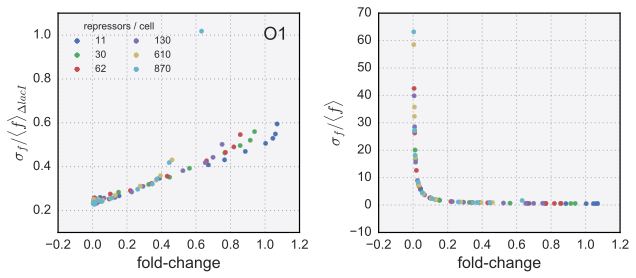

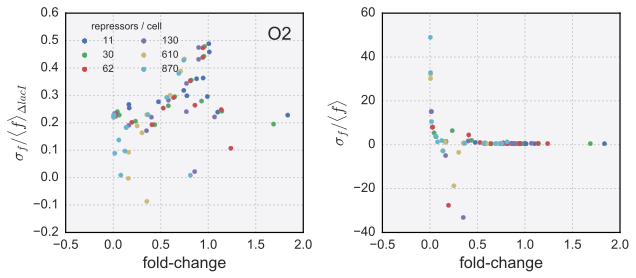

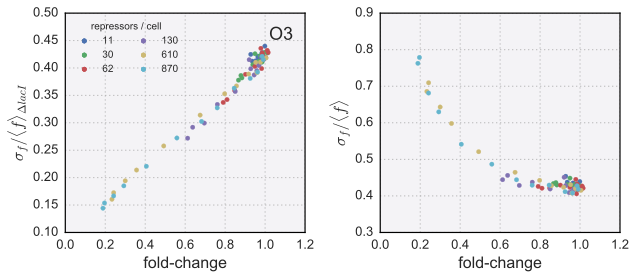

In [131]:
operators = ['O1', 'O2', 'O3']
for operator in operators:
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))

    colors = sns.color_palette(n_colors=7)
    for i, rbs in enumerate(np.sort(df_noise.repressors.unique())):
        # Extract the data and compute the mean and std
        df_rbs = df_noise[(df_noise.operator==operator) & \
                          (df_noise.repressors==rbs)]
        mean_rbs = df_rbs.groupby('IPTG').mean_fluor_bgcorr.mean()
        fc_rbs = df_rbs.groupby('IPTG').fold_change.mean()
        std_rbs = df_rbs.groupby('IPTG').std_fluor.mean()
        std_norm = df_rbs.groupby('IPTG').std_norm.mean()
        # plot the data
        ax[0].scatter(fc_rbs, std_norm, label=rbs, color=colors[i])
        ax[1].scatter(fc_rbs, std_rbs / mean_rbs, color=colors[i])

    ax[0].set_xlabel('fold-change')
    ax[0].set_ylabel(r'$\sigma_f / \langle f \rangle_{\Delta lacI}$')
    ax[0].legend(loc='upper left', title='repressors / cell', ncol=2)
    ax[0].text(0.9, 0.9, operator, fontsize=18, ha='center', va='center',
               transform=ax[0].transAxes)

    ax[1].set_xlabel('fold-change')
    ax[1].set_ylabel(r'$\sigma_f / \langle f \rangle$')
    ax[1].ticklabel_format(axis='x',style='sci',scilimits=(1,3))

    fig.tight_layout()
#     plt.savefig(figdir + 'foldchange_vs_std_norm_' + operator + '.pdf')

The standard deviation seems to scale linearly with the mean fluorescence level.

We can calculate from this information the channel capacity using the small noise approximation. Let's define a function that given a set of pairs (mean, std) performs a spline interpolation and numerically integrates the inverse of that interpolation.

In [42]:
def small_noise_int(df, spline_kind='cubic'):
    '''
    Given a set of mean and standard deviation values performs a spline
    interpolation and integrates in the adecuate interval, returning the
    channel capacity.
    Parameters
    ----------
    df : pandas DataFrame.
        DataFrame containing two columns with the mean fluorescence level
        mean_fluor and the standard deviation std_fluor
    spline_kind : str.
        Kind of spline that should be fit to the data.
    
    Returns
    -------
    channel capacity : float
        channel capacity as computed with the small noise approximation
    '''
    # Perform the spline interpolation
    noise_spline = scipy.interpolate.interp1d(df.mean_fluor, df.std_fluor, 
                                              kind=spline_kind)
    # Define lambda function to get the inverse of the spline interpolation
    inv_sigma = lambda x: 1 / noise_spline(x)
    # Numerically integrate the function
    Z = scipy.integrate.quad(inv_sigma, df.mean_fluor.min(), 
                             df.mean_fluor.max())
    
    return np.log2(Z[0] / np.sqrt(2 * np.pi * np.e))

In [46]:
grouping = ['operator', 'rbs', 'chan_cap']
df_sma_mean = pd.DataFrame()
for g, p in df_noise.groupby(grouping[:-1]):
    g = list(g)
    mean = pd.DataFrame(p.groupby('IPTG').mean_fluor.mean())
    std = pd.DataFrame(p.groupby('IPTG').std_fluor.mean())
    data = pd.concat([mean, std], axis=1)
    g.append(small_noise_int(data, 'linear'))
    df_sma_mean = df_sma_mean.append(pd.Series(g, index=grouping), 
                                     ignore_index=True)

/Users/razo/anaconda/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [47]:
df_sma_mean

chan_cap operator      rbs
0  -0.633380       O1    HG104
1  -1.563246       O1     RBS1
2  -0.972757       O1  RBS1027
3  -0.733818       O1  RBS1147
4  -1.357677       O1    RBS1L
5  -0.835418       O1   RBS446
6  -0.759672       O2    HG104
7  -0.728587       O2     RBS1
8  -0.472337       O2  RBS1027
9  -0.472577       O2  RBS1147
10 -0.739510       O2    RBS1L
11 -0.457548       O2   RBS446
12 -4.040454       O3    HG104
13 -0.593762       O3     RBS1
14 -1.920256       O3  RBS1027
15 -3.292835       O3  RBS1147
16 -0.436060       O3    RBS1L
17 -2.790422       O3   RBS446

All of the channel capacity values are negative. This means that the noise level is in the regime where the small-noise approximation does not apply. And that can actually be seen from the mean fluorescence vs. noise plot. There we can see that at the highest mean fluoresence level the noise (standar deviation divided by the mean) is about 0.4. This is definitely outside of the range where the approximation can be used.